# Ex - Univariate Time Series Prediction

Machine Learning methods can be used for a huge variety of tasks, besides building classifiers. One simple example is so-called _regression_, i.e. the task of learning a real-value function.

In this exercise we will tackle a regression problem, defined over a time series. In particular, we will try to build an auto-regressor to predict the trend of CO concentration in an Italian city over (roughly) one year.

In the context of time-series, an auto-regressor is simply a function that tries to predict the next value of the time series based on previous values of the times series itself.

Our goal will be to improve an initial classifier, trying to raise its predictive accuracy as much as possible: we will use fully-connected layers and convolutions.

## Loading data

We will start by loading the data, by using a function that has been prepared in the "lutil.py" file (included in the zip archive).

The function has signature:

```python
def load_air_data(fname)
```

The function returs a [pandas](https://pandas.pydata.org) dataframe, a data structure for a table with an explicit index and named columns.

Here is the code to load the data:

In [2]:
import lutil

data = lutil.load_air_data()

print(data.describe()) # Shows statistical information about each column
data.head()

            CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7674.000000  8991.000000   914.000000  8991.000000    8991.000000   
mean      2.152750  1099.833166   218.811816    10.083105     939.153376   
std       1.453252   217.080037   204.459921     7.449820     266.831429   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.500000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7718.000000   8991.000000  7715.000000   8991.000000  8991.000000   
mean    246.896735    835.493605   113.091251   1456.264598  1022.906128   
std     212.979168    256.817320    48.370108    346.206794   398.484288   
min       2

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Samples have been collected with the frequency of one hour.

For the moment, we will use only the the `CO(GT)` column for training, plus the DataFrame index, which contains the sample date.

We will also discard all rows containing missing values. This is probably not a good idea (knowning that we have "skipped" some days may be useful for the predictor), but let's keep everything as simple as possible.

In [3]:
import numpy as np

data = data[['CO(GT)']] # Still a DataFrame, not a Series
data = data.dropna() # Discard tuples with NaN values
data.head()

,CO(GT)
Date,
2004-03-10 18:00:00,2.6
2004-03-10 19:00:00,2.0
2004-03-10 20:00:00,2.2
2004-03-10 21:00:00,2.2
2004-03-10 22:00:00,1.6


When you have a time-series it is usually a good idea to plot it: this can be done easily with matplotlib.

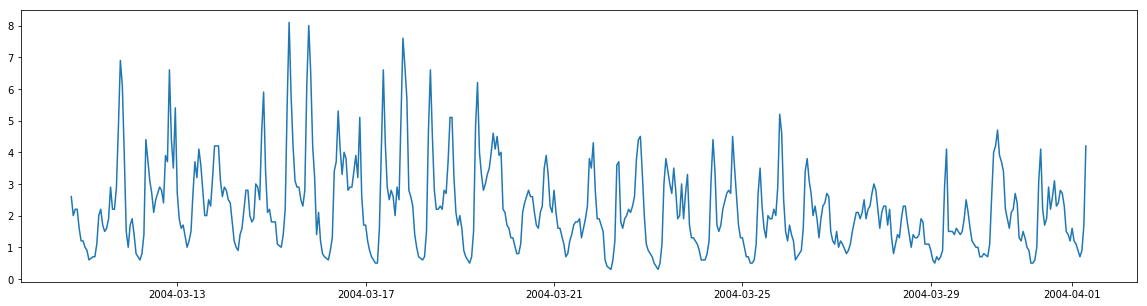

In [6]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(data.index[:500], data['CO(GT)'].values[:500])
plt.show()

The series does not exhibit a strong trend, which is good news (we can skip de-trending).

There seems to be some kind of periodicity, however. We can try to highlight it by plotting the autocorrelation function:

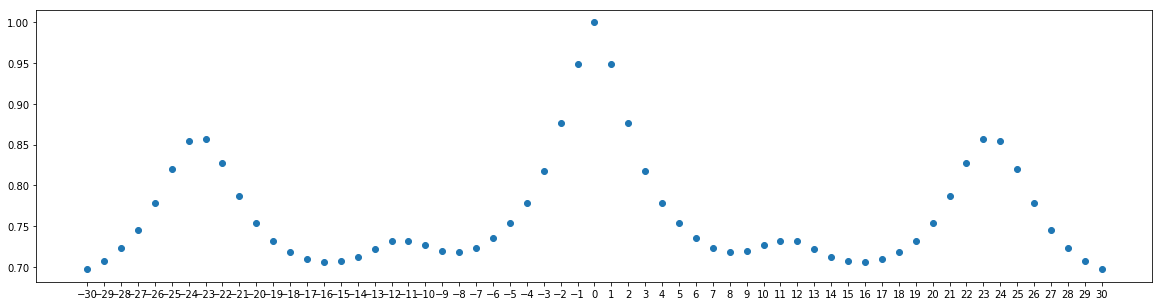

In [7]:
import pandas as pd

plt.figure(figsize=(20, 5))
#pd.plotting.autocorrelation_plot(data['CO(GT)'].iloc[:50])
lags, _, _, _ = plt.acorr(data['CO(GT)'].values, usevlines=False, maxlags=30)
plt.xticks(lags)
plt.show()

There seems to be a strong dependency between sample taken 24 hours apart, which make sense.

A weaker (but still somehow significant) correlation exist between sample around 11-12 hours apart.

Let's have a look at the probability distribution of our data

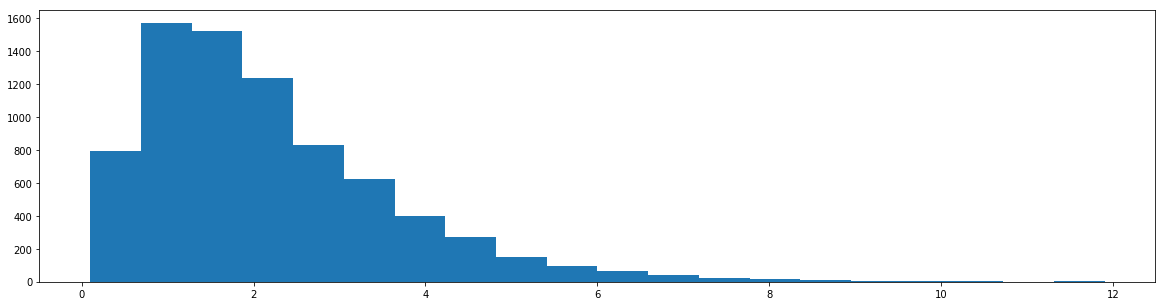

In [8]:
plt.figure(figsize=(20, 5))
plt.hist(data['CO(GT)'], bins=20)
plt.show()

This looks log-Normal-ish, meaning that we can probably obtain roughly Normally distributed data via a simple transformation.

Linear methods (i.e. those that we will use in this hands-on session) tend to work a bit better with Normally distributed data.

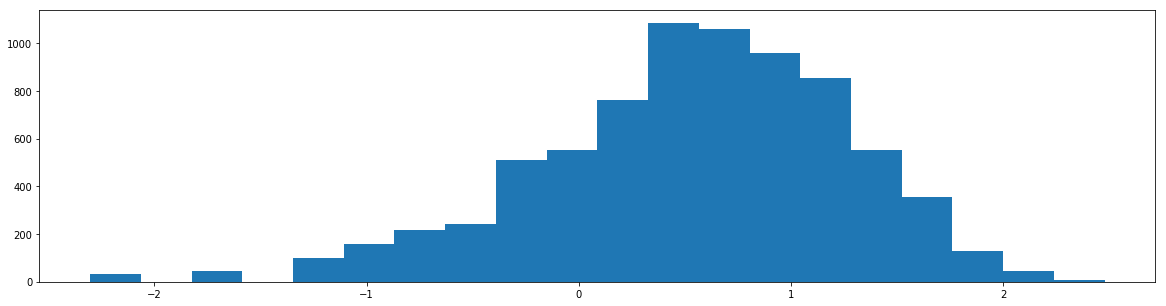

In [9]:
import numpy as np

data['CO(GT)'] = np.log(data['CO(GT)'])

plt.figure(figsize=(20, 5))
plt.hist(data['CO(GT)'], bins=20)
plt.show()

Still not actually Normal, but much closer now.

## Normalization/Standardization

As usual, before we can train our model, we need to normalize the data. We will use a standardization approach, taking care to compute the mean and standard deviation only on data from the training set.

In [11]:
# Choose a separator date for the training and test set
# NOTE: it's important to compute the means and standard deviations only on the training data!
sep = data.index[-500]

# Standardize the data
means = data[data.index < sep].mean(axis=0)
stds = data[data.index < sep].std(axis=0)
data = (data - means) / stds

data.head()

,CO(GT)
Date,
2004-03-10 18:00:00,0.574906
2004-03-10 19:00:00,0.217380
2004-03-10 20:00:00,0.347260
2004-03-10 21:00:00,0.347260
2004-03-10 22:00:00,-0.086700


## Building the Training and Test Set

We can now build our training and test set, which will be a bit unusual, since we are trying to predict future values based on past values.

The main idea of our predictor is this:

* We will use the data about a period of N days (year days and stock prices)...
* ...To predict the stock price on te N+1th day

Therefore, in order to build the trainig/test set we will need to consider all time-windows of N consecutive days. The corresponding target value will be the value for the day immediately after.

Good values for N in our case should be 10 and 24. The latter should be better in principle (stronger auto-correlation), but 24 inputs instead of 10 is a significant increase, which may have an adverse effect on the training process (more on this later).

We will store the training input in an array with shape:

```python
(nsamples, nsteps, nseries)
```

where `nseries` will be equal to 1 in our case (because we are dealing with a univariate series). This choice is actually due to compatibility issues with other python packages.

Here is the code to build the training set:

In [13]:
targets = data.columns
nsteps_in = 24

index, x_all, y_all = lutil.sliding_win_ds(data, targets, nsteps_in)

print(index[:2])
print(x_all.shape)
print(y_all.shape)

DatetimeIndex(['2004-03-11 19:00:00', '2004-03-11 20:00:00'], dtype='datetime64[ns]', name='Date', freq=None)
(7650, 24, 1)
(7650, 1, 1)


Most of the heavy lifting is done by the `sliding_win_ds` function, which is provided for convenience in the `lutil` module. The function returns:

* A index of the dates for which we can attempt a prediction
* The corresponding input values (intuitively each one a row in `x_all`)
* The corresponding true values of the CO2 concentration

Notice that the datasets have:

* One dimension for the samples
* One dimension for the time steps
* One dimension for the different "types" of value being tracked.

Since we are dealing with a univariate series, the last dimension is always 1 and we can get rid of that:

In [14]:
x_all = x_all.reshape(len(x_all), -1)
y_all = y_all.reshape(len(y_all), -1)

print(x_all.shape)
print(y_all.shape)

(7650, 24)
(7650, 1)


We can now separate out training and test set (we use or separator from before):

In [15]:
# Separate training and test set
train_mask = index < sep
x_train, y_train = x_all[train_mask], y_all[train_mask]
index_train = index[train_mask]
test_mask = index >= sep
x_test, y_test = x_all[test_mask], y_all[test_mask]
index_test = index[test_mask]

## Building the model

We can now define the model, train it, and perform the evaluation. We will use a very simple mode, i.e. a linear combination of the input features:
$$
f(x) = \sum_{i=1}^{n} w_i x_i
$$

We start by creating a `LinearRegression` model in scikit-learn:

In [16]:
from sklearn import linear_model

# Model 1: simple linear regressor
model = linear_model.LinearRegression()

The model object has a few parameters that can be used to control its behavior. Detailed information can be found [on  the scikit-learn web site](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) or via the on-line help:

In [21]:
model = linear_model.LinearRegression?

In [ ]:
model = linear_model.LinearRegression

Training the model is done by calling the `fit` function

In [22]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [23]:
model.coef_

array([[-7.69904948e-02,  1.13496952e-01,  1.01987149e-01,
         3.07006410e-02, -1.39334822e-02, -1.46671626e-03,
         7.95179266e-05, -2.03866556e-02,  3.20375460e-02,
         2.22055076e-02, -3.36042977e-02, -4.99629969e-02,
         3.47975148e-02, -2.46338215e-04,  4.72313881e-02,
        -2.71847805e-02, -2.28597540e-02,  3.89956857e-02,
        -3.38482572e-02,  5.55599214e-02, -2.88688513e-02,
        -1.26789577e-02, -2.94759856e-01,  1.06950338e+00]])

Now we need to measure the performance. During training we have used the mean squared error, i.e.:

$$
MSE = \frac{1}{n} \sum_{i=1}^n (y_i - p_i)^2
$$

where $y_i$ if the true value of the target and $p_i$ is our prediction. Basically, we take all the errors, we square them, and we compute the average. The MSE works well a los function for training, but it is not very understandable.

For evaluating the model quality, we will use instead the mean _absolute_ error, which is given by:

$$
MAE = \frac{1}{n} \sum_{i=1}^n |y_i - p_i|
$$

The mean absolute error is more difficult to optimize (because it is non-smooth in 0), but easier to interpret.

We will also evalauate the quality via the coefficient of determination:

$$
R2 = 1 - \frac{\sum_{i=1}^n (y_i - p_i)^2}{\sum_{i=1}^n (y_i - \overline{y})^2}
$$

We start by obtaining the predictions for both the trainign and the test set:

In [24]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

Then, scikit-learn provides some convenient functions to compute the most commonly used metrics:

In [25]:
from sklearn import metrics

mse_train = metrics.mean_squared_error(y_train, pred_train)
mae_train = metrics.mean_absolute_error(y_train, pred_train)
r2_train = metrics.r2_score(y_train, pred_train)

mse_test = metrics.mean_squared_error(y_test, pred_test)
mae_test = metrics.mean_absolute_error(y_test, pred_test)
r2_test = metrics.r2_score(y_test, pred_test)

print('std, training set (model): %f' % (y_train.std()))
print('std, test set (model): %f' % (y_test.std()))
print('MSE, training set (model): %f' % (mse_train))
print('MSE, test set (model): %f' % (mse_test))
print('MAE, training set (model): %f' % (mae_train))
print('MAE, test set (model): %f' % (mae_test))
print('R2, training set (model): %f' % (r2_train))
print('R2, test set (model): %f' % (r2_test))

std, training set (model): 1.000825
std, test set (model): 0.923169
MSE, training set (model): 0.197849
MSE, test set (model): 0.163163
MAE, training set (model): 0.318840
MAE, test set (model): 0.276825
R2, training set (model): 0.802477
R2, test set (model): 0.808548


We can also have a direct look at the error distribution:

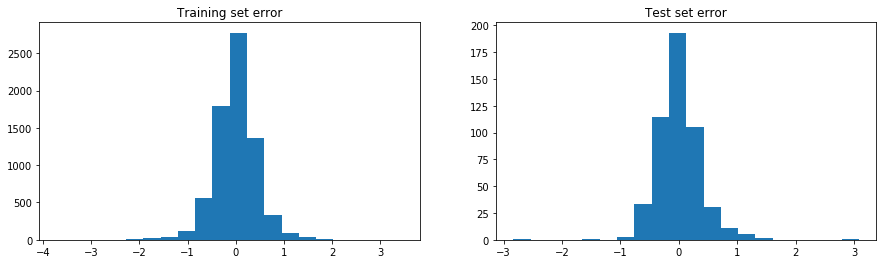

In [26]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.title('Training set error')
plt.hist(y_train - pred_train, bins=20)
plt.subplot(1,2,2)
plt.title('Test set error')
plt.hist(y_test - pred_test, bins=20)
plt.show()

However, if we want to be really meaningful, we should also have some kind of baseline.

For time series, a ready baseline is given by the persistence model, which assume that the last value just repeats forever.

In [27]:
# Obtain the baseline (simple persistence model)
baseline = lutil.persistence_baseline(data, targets, nsteps_in)
baseline = baseline.reshape(len(baseline), -1)

b_train = baseline[index < sep]
b_test = baseline[index >= sep]

print(baseline[:5])

[[ 1.41038855]
 [ 1.90492302]
 [ 1.73699283]
 [ 1.12743658]
 [-0.17464718]]


/Users/lompa/Documents/Teaching/BBS 2019 - Master in Digital Technology Management/lab01/lutil.py:199: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y = np.stack( (data[nsteps_in-1:nsteps_in-totwidth or None:stepsize][targets] for i in range(nsteps_in, nsteps_in+nsteps_out)), axis=1)


We can then compute our evaluation metrics:

In [28]:
# Evaluate using numeric metrics
b_mae_train = metrics.mean_absolute_error(y_train, b_train)
b_r2_train = metrics.r2_score(y_train, b_train)

b_mae_test = metrics.mean_absolute_error(y_test, b_test)
b_r2_test = metrics.r2_score(y_test, b_test)

print('R2, training set (model, baseline): %f, %f' % (r2_train, b_r2_train))
print('R2, test set (model, baseline): %f, %f' % (r2_test, b_r2_test))
print('MAE, training set (model, baseline): %f, %f' % (mae_train, b_mae_train))
print('MAE, test set (model, baseline): %f, %f' % (mae_test, b_mae_test))

R2, training set (model, baseline): 0.802477, 0.719909
R2, test set (model, baseline): 0.808548, 0.688120
MAE, training set (model, baseline): 0.318840, 0.381242
MAE, test set (model, baseline): 0.276825, 0.361294


Good news: we are doing better!

We also can depict our prediction visually via scatter plot:

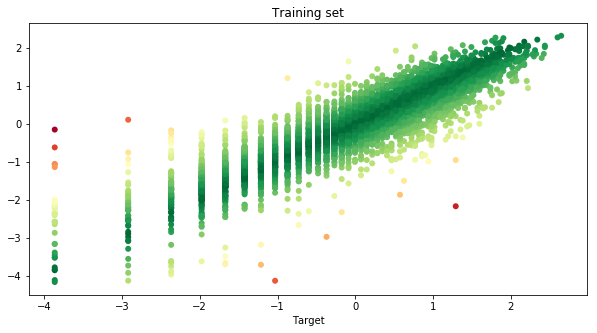

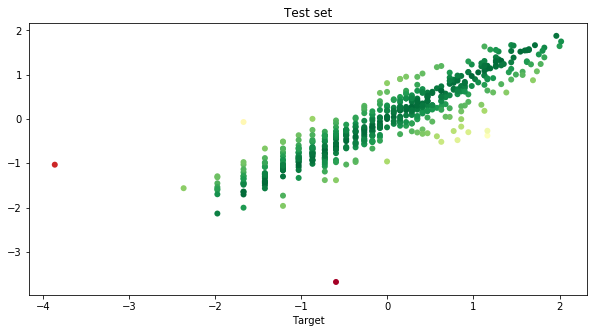

In [29]:
# Plot the prediction and the real values against each other
lutil.pred_real_scatter(y_train, pred_train, 'Training set')
lutil.pred_real_scatter(y_test, pred_test, 'Test set')

And plot the predicted values over time, for the test set. Remember that each prediction assumes that the true value of the N previous sample is known:

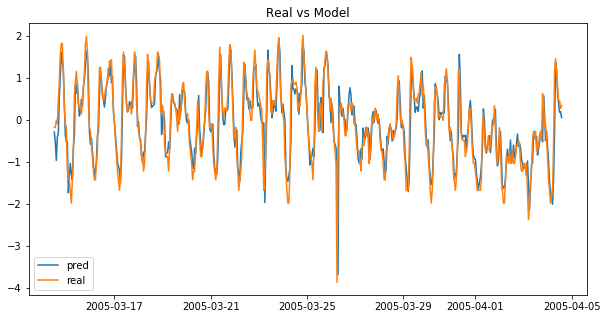

In [30]:
# Reconstruct the real-scale value
p_test_rs = lutil.de_standardize(pred_test, means, stds)
y_test_rs = lutil.de_standardize(y_test, means, stds)
b_test_rs = lutil.de_standardize(b_test, means, stds)

# Plot the two series over time
lutil.pred_real_plot(index_test, y_test_rs, p_test_rs, 'Real vs Model')
#lutil.pred_real_plot(index_test, y_test_rs, b_test_rs, 'Real vs Model')

It is also very interesting to have a look at the model, i.e. at the coeffcients of the sum:

$$
f(x) = \sum_{i=1}^{n} w_i x_i
$$

Note that, since we didn't tell it not to, scikit-learn has also tried to fit an intercept (i.e. a constant offset). Both are stored as fields in the `LinearRegression` object:

In [23]:
print('Coefficients', model.coef_)
print('Intercept', model.intercept_)

Coefficients [[-7.69904948e-02  1.13496952e-01  1.01987149e-01  3.07006410e-02
  -1.39334822e-02 -1.46671626e-03  7.95179266e-05 -2.03866556e-02
   3.20375460e-02  2.22055076e-02 -3.36042977e-02 -4.99629969e-02
   3.47975148e-02 -2.46338215e-04  4.72313881e-02 -2.71847805e-02
  -2.28597540e-02  3.89956857e-02 -3.38482572e-02  5.55599214e-02
  -2.88688513e-02 -1.26789577e-02 -2.94759856e-01  1.06950338e+00]]
Intercept [-0.00055213]


Here is a visual depiction, for clarity:

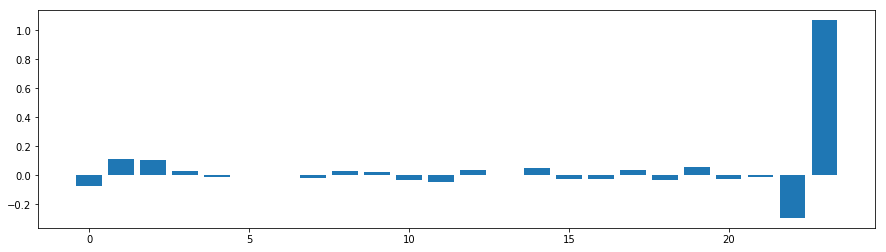

In [31]:
plt.figure(figsize=(15, 4))
plt.bar(range(nsteps_in), model.coef_[0])
plt.show()

As we can see, the model is doing most of the work using the last time step 